In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
connect=sqlite3.connect('../data/checking-logs.sqlite', check_same_thread=False)

In [13]:
df=pd.io.sql.read_sql('select * from pageviews where uid not like "admin_%" ', connect, parse_dates=['timestamp'])
df

,index,uid,datetime
0,12,user_30,2020-04-17 22:46:26.785035
1,14,user_14,2020-04-18 10:53:52.623447
2,15,user_17,2020-04-18 10:56:55.833899
3,16,user_14,2020-04-18 10:57:37.331258
4,18,user_17,2020-04-18 12:05:48.200144
...,...,...,...
982,1073,user_28,2020-05-21 18:45:20.441142
983,1074,user_19,2020-05-21 23:03:06.457819
984,1075,user_25,2020-05-21 23:23:49.995349
985,1078,user_5,2020-05-22 11:30:18.368990


In [8]:
query='select uid, count(timestamp) as nums_commits from checker where labname <> "project1" and uid like "user_%" group by uid'
nums_commits=pd.io.sql.read_sql(query, connect)
nums_commits.head()

,uid,nums_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86


In [12]:
query="""select uid, cast((strftime('%s', test.first_commit_ts) - deadlines.deadlines)/3600 as integer) as delta from test
left join deadlines on test.labname=deadlines.labs where labname <> 'project1'"""

avg_diff=pd.io.sql.read_sql(query, connect)
avg_diff.head()

,uid,delta
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148


In [15]:
query="""select uid, count(datetime) as pageviews from pageviews where uid like 'user_%' group by uid """
pageviews=pd.io.sql.read_sql(query, connect)
pageviews.head()

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


In [ ]:
#так как у некоторых пользователей несколько дельт, посчитаем среднюю дельту для каждого
avg_diff=avg_diff.groupby("uid").mean()
avg_diff.head()

,delta
uid,
user_1,-64.400000
user_10,-74.800000
user_14,-159.000000
user_17,-61.600000
user_18,-5.666667


In [19]:
table_stat=nums_commits.merge(avg_diff, on="uid")
table_stat=pageviews.merge(table_stat, on="uid")
table_stat.head()

,uid,pageviews,nums_commits,delta
0,user_1,28,62,-64.400000
1,user_10,89,20,-74.800000
2,user_14,143,61,-159.000000
3,user_17,47,51,-61.600000
4,user_18,3,5,-5.666667


In [21]:
table_stat=table_stat.drop(columns="uid")
table_stat.head()

,pageviews,nums_commits,delta
0,28,62,-64.400000
1,89,20,-74.800000
2,143,61,-159.000000
3,47,51,-61.600000
4,3,5,-5.666667


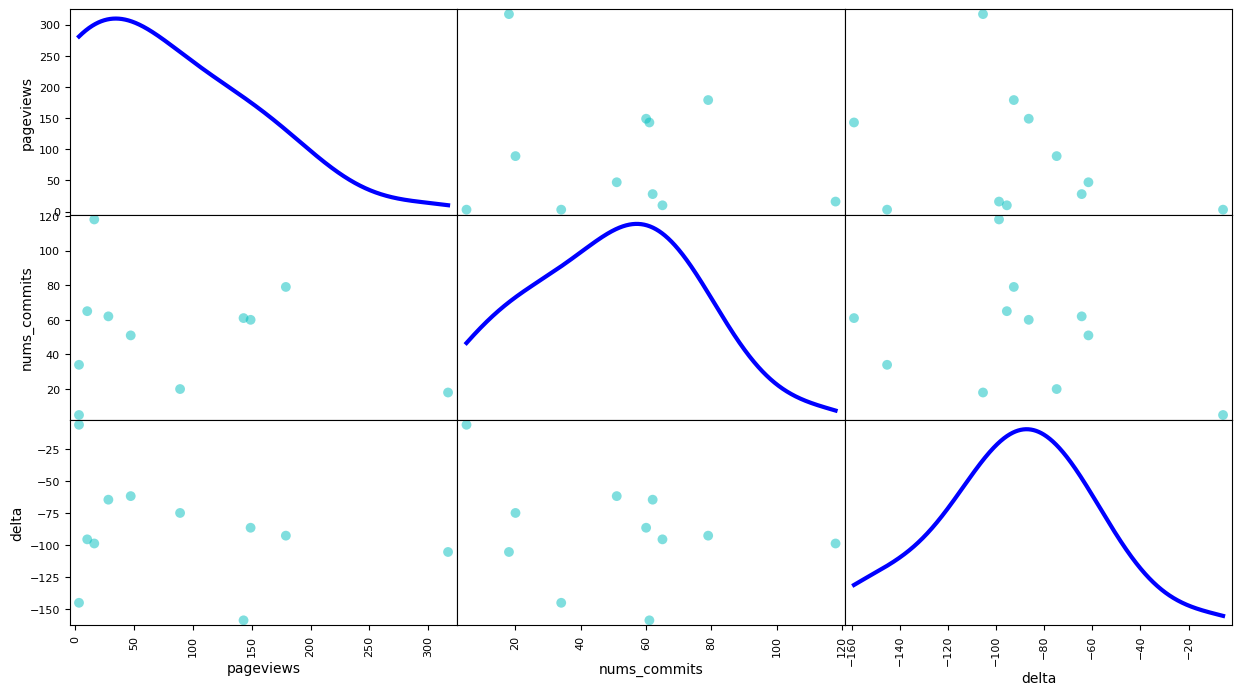

In [31]:
graph=scatter_matrix(table_stat,figsize=(15,8), color='c', diagonal='kde', density_kwds=dict(linewidth=3, color='b'), s=200)

#### Can we say that if a user has a low number of pageviews then they likely have a low number of commits?

no

#### Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?

no

#### Can we say that there are many users with a low number of commits and a few with a high number of commits”?

no, there are a lot of in the middle

#### Can we say that there are many users with a small average difference and a few with a large average difference”?

no, there are many in the middle